# AdventureWorks Försäljningsanalys
I denna analys undersöker jag AdventureWorks-databasen för att besvara affärsfrågor som exempelvis:
- Produktkategorier och deras försäljning
- Försäljningstrender över tid
- Regional försäljning

Använder SQL för att hämta data och Python för visualisering och analys.

In [ ]:
from sqlalchemy import create_engine, text
from urllib.parse import quote_plus
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


SERVER = "localhost:1433"
DATABASE = "AdventureWorks2025"
USERNAME = "SA"
PASSWORD = quote_plus("Bilal424")
DRIVER = "SQL Server"   


ENGINE_URL = (
    f"mssql+pyodbc://{USERNAME}:{PASSWORD}@{SERVER}/{DATABASE}"
    f"?driver={DRIVER}"
    f"&TrustServerCertificate=yes"
)

engine = create_engine(ENGINE_URL)


with engine.connect() as conn:
    conn.execute(text("SELECT 1"))
    print("ANSLUTNING FUNGERAR – AdventureWorks2025")

ANSLUTNING FUNGERAR – AdventureWorks2025


C:\Users\bilal\AppData\Local\Temp\ipykernel_27624\2830558072.py:25: SAWarning: Unrecognized server version info '17.0.1000.7'.  Some SQL Server features may not function properly.
  with engine.connect() as conn:


## Antal produkter per kategori
Hur många produkter finns i varje kategori?



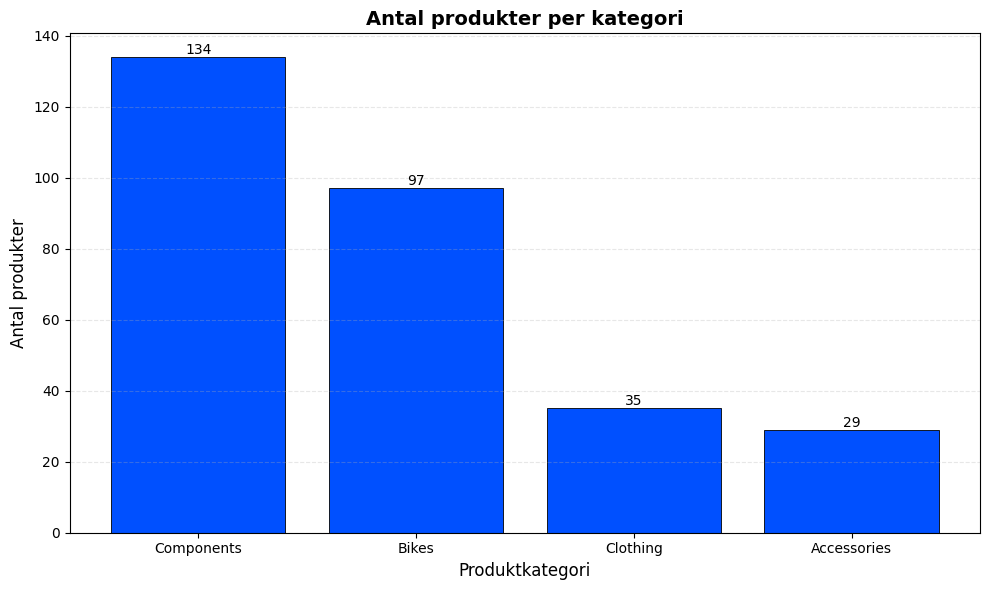

In [3]:
query_vis1 = """
SELECT
	pc.Name AS CategoryName,
	COUNT(DISTINCT p.ProductID) AS ProductCount
FROM Production.ProductCategory pc
INNER JOIN Production.ProductSubcategory psc ON pc.ProductCategoryID = psc.ProductCategoryID
INNER JOIN Production.Product p ON psc.ProductSubcategoryID = p.ProductSubcategoryID
GROUP BY pc.Name
ORDER BY ProductCount DESC
"""

df_vis1 = query_df(query_vis1)

fig, ax = plt.subplots(figsize=(10,6))

bars = ax.bar(
    df_vis1['CategoryName'],
    df_vis1['ProductCount'],
    color='#0050FF',       
    alpha=1.0,             
    edgecolor='black',    
    linewidth=0.6
)

for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2,
        height,
        f'{int(height)}',
        ha='center',
        va='bottom',
        fontsize=10
    )

ax.set_xlabel('Produktkategori', fontsize=12)
ax.set_ylabel('Antal produkter', fontsize=12)
ax.set_title('Antal produkter per kategori', fontsize=14, fontweight='bold')

ax.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

### Insikter - Antal produkter per kategori
Produktkategorin Components har flest produkter med totalt 134 stycken, medan Accessories har minst med 29 produkter. Detta visar att företaget främst satsar på komponenter och reservdelar, och att tillbehör kan vara ett område med potential för vidare utveckling. 

## Försäljning per produktkategori
Vilka produktkategorier generar mest intäkter?



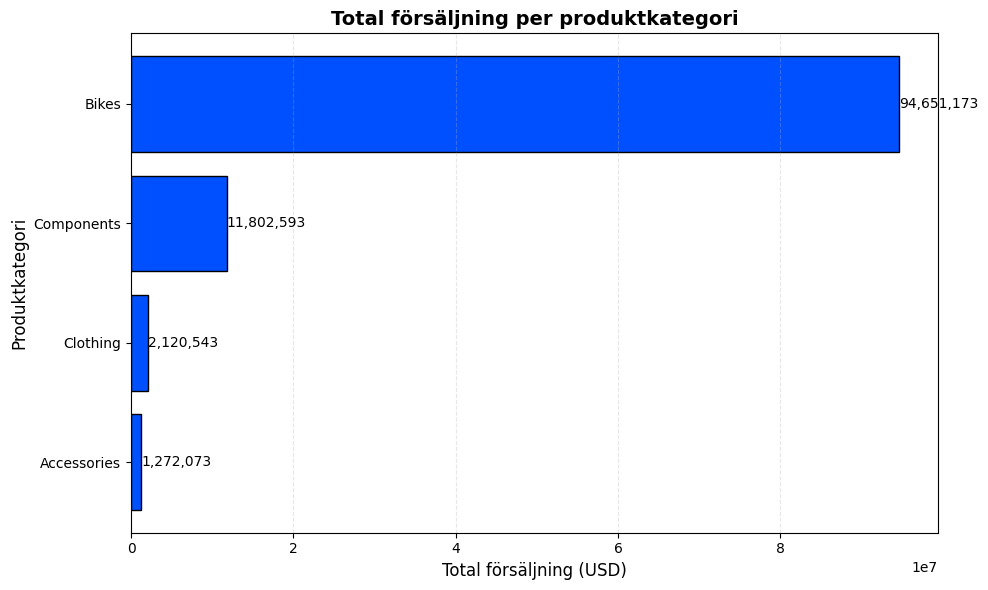

In [4]:
query_vis2 = """
SELECT
	pc.Name AS CategoryName,
	SUM(sod.LineTotal) AS TotalSales
FROM Production.ProductCategory pc
INNER JOIN Production.ProductSubcategory psc ON pc.ProductCategoryID = psc.ProductCategoryID
INNER JOIN Production.Product p ON psc.ProductSubcategoryID = p.ProductSubcategoryID
INNER JOIN Sales.SalesOrderDetail sod ON p.ProductID = sod.ProductID
GROUP BY pc.Name
ORDER BY TotalSales DESC
"""

df_vis2 = query_df(query_vis2)

fig, ax = plt.subplots(figsize=(10,6))

bars = ax.barh(
    df_vis2['CategoryName'],
    df_vis2['TotalSales'],
    color='#0050FF',       
    alpha=1.0,             
    edgecolor='black',     
)

for bar in bars:
    width = bar.get_width()
    ax.text(
        width,
        bar.get_y() + bar.get_height()/2,
        f'{width:,.0f}',
        va='center',
        ha='left',
        fontsize=10
    )

ax.set_xlabel('Total försäljning (USD)', fontsize=12)
ax.set_ylabel('Produktkategori', fontsize=12)
ax.set_title('Total försäljning per produktkategori', fontsize=14, fontweight='bold')

ax.invert_yaxis()
ax.grid(axis='x', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

### Insikter - Försäljning per produktkategori
Bikes är den produktkategori som står för störst del av försäljningen, med totalt cirka 94,6 miljoner USD, vilket motsvarar runt 880 miljoner SEK. Accessories har lägst försäljning med cirka 1,3 miljoner USD, eller ungefär 12 miljoner SEK. Resultatet visar att företagets intäkter till stor del kommer från cyklar, vilket sannolikt beror på att cyklar har ett betydligt högre pris per styck jämfört med andra produkter.

##Försäljningstrend över tid
Hur har försäljningen utvecklats över tid?



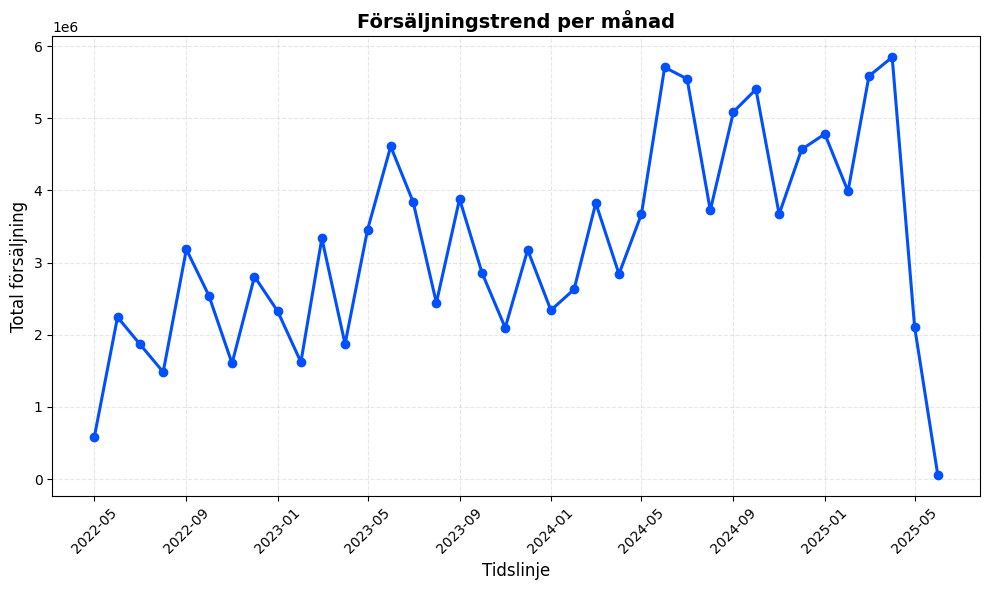

In [5]:
query_vis3 = """
SELECT
	YEAR(OrderDate) AS SalesYear,
	MONTH(OrderDate) AS SalesMonth,
	SUM(TotalDue) AS TotalSales
FROM Sales.SalesOrderHeader
GROUP BY
	YEAR(OrderDate),
	MONTH(OrderDate)
ORDER BY
	YEAR(OrderDate) ASC,
	MONTH(OrderDate) ASC
    """

df_vis3 = query_df(query_vis3)

df_vis3['SalesDate'] = pd.to_datetime(
    df_vis3.rename(columns={'SalesYear': 'year', 'SalesMonth': 'month'})
                .assign(day=1)[['year','month','day']]
)

fig, ax = plt.subplots(figsize=(10,6))

ax.plot(
    df_vis3['SalesDate'],
    df_vis3['TotalSales'],
    marker='o',
    color='#0050FF',    
    linewidth=2.2,       
    markersize=6,
    alpha=1.0            
)

ax.set_xlabel('Tidslinje', fontsize=12)
ax.set_ylabel('Total försäljning', fontsize=12)
ax.set_title('Försäljningstrend per månad', fontsize=14, fontweight='bold')

ax.grid(True, linestyle='--', alpha=0.3)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### Insikter - Försäljningstrend över tid
Försäljningen visar en tydligt ökande trend under perioden 2022 till 2025. Det kraftiga fallet i slutet av juni 2025 beror troligen på att många ordrar ännu inte har förfallodatum förrän i juli, vilket gör att försäljningen ser lägre ut än den egentligen är. Den låga försäljningen i maj 2022 beror på att det saknas data för hela månaden. Den högsta försäljningen sker i april 2025 med cirka 5,8 miljoner USD, medan augusti 2022 är den svagaste månaden med cirka 1,5 miljoner USD när ofullständiga månader räknas bort. Mönstret visar även att försäljningen är säsongsberoende, med högre nivåer under sommaren och lägre under vintern.

## Försäljning och antal ordrar per år
Hur ser total försäljning och antal ordrar ut per år?


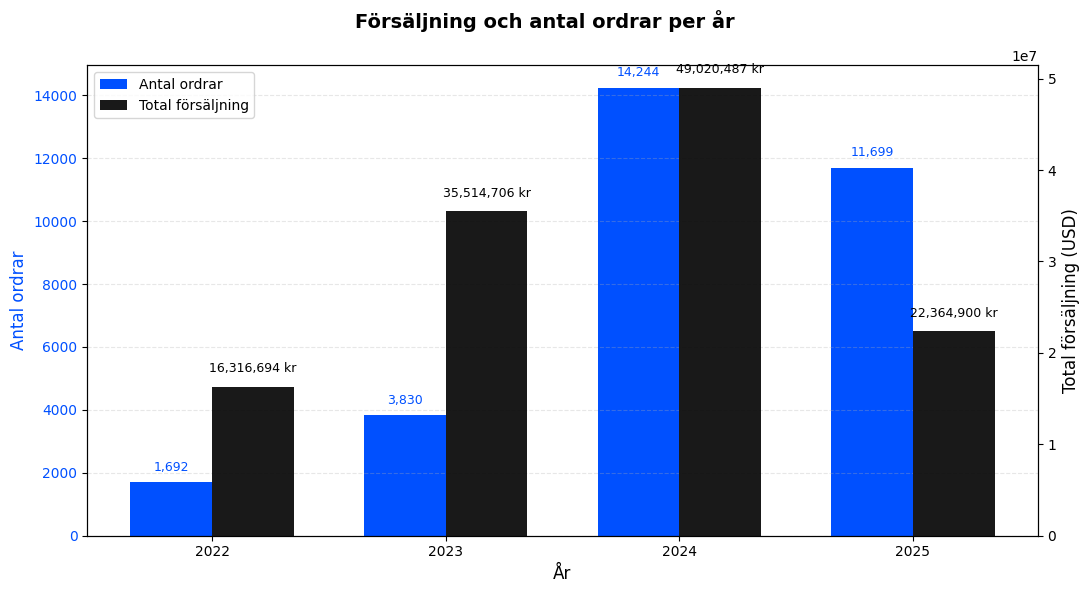

In [11]:
query_vis4 = """
SELECT
	YEAR(OrderDate) AS SalesYear,
	COUNT(DISTINCT SalesOrderID) AS AntalOrdrar,
	SUM(TotalDue) AS TotalSales
FROM Sales.SalesOrderHeader
GROUP BY
	YEAR(OrderDate)
ORDER BY
	YEAR(OrderDate) ASC
    """

df_vis4 = query_df(query_vis4)

import numpy as np

x = np.arange(len(df_vis4))
width = 0.35

fig, ax1 = plt.subplots(figsize=(11,6))

bars_orders = ax1.bar(
    x - width/2,
    df_vis4['AntalOrdrar'],
    width,
    label='Antal ordrar',
    color='#0050FF',
    alpha=1.0
)

ax1.set_ylabel('Antal ordrar', fontsize=12, color='#0050FF')
ax1.tick_params(axis='y', labelcolor='#0050FF')

ax2 = ax1.twinx()

bars_sales = ax2.bar(
    x + width/2,
    df_vis4['TotalSales'],
    width,
    label='Total försäljning',
    color='black',
    alpha=0.9
)

ax2.set_ylabel('Total försäljning (USD)', fontsize=12, color='black')
ax2.tick_params(axis='y', labelcolor='black')

for bar in bars_orders:
    height = bar.get_height()
    ax1.annotate(
        f'{int(height):,}',
        xy=(bar.get_x() + bar.get_width()/2, height),
        xytext=(0, 6),
        textcoords='offset points',
        ha='center',
        va='bottom',
        fontsize=9,
        color='#0050FF'
    )

for bar in bars_sales:
    height = bar.get_height()
    ax2.annotate(
        f'{height:,.0f} kr',
        xy=(bar.get_x() + bar.get_width()/2, height),
        xytext=(0, 8),
        textcoords='offset points',
        ha='center',
        va='bottom',
        fontsize=9,
        color='black'
    )

ax1.set_xlabel('År', fontsize=12)
ax1.set_xticks(x)
ax1.set_xticklabels(df_vis4['SalesYear'])

fig.suptitle(
    'Försäljning och antal ordrar per år',
    fontsize=14,
    fontweight='bold'
)

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2, loc='upper left')

ax1.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

### Försäljning och antal ordrar per år
Åren 2022 och 2025 innehåller endast data för delar av året och är därför inte fullständiga. Om man i stället jämför 2023 och 2024 syns en tydlig ökning av både försäljning och antal ordrar. År 2024 hade den högsta försäljningen med cirka 49 miljoner USD, vilket motsvarar ungefär 455 miljoner SEK.

## Top 10 produkter
Vilka 10 produkter genererar mest försäljning?

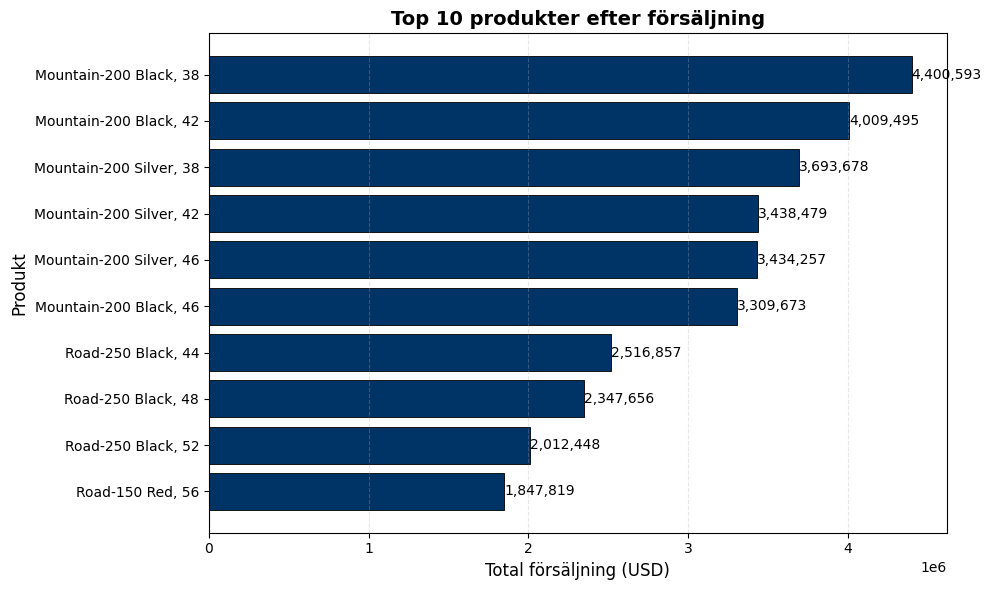

In [7]:
query_vis5 = """
SELECT TOP 10
	p.Name AS Namn,
	SUM(sod.LineTotal) AS TotalSales
FROM Production.Product p
INNER JOIN Sales.SalesOrderDetail sod ON p.ProductID = sod.ProductID
GROUP BY p.Name
ORDER BY TotalSales DESC
"""

df_vis5 = query_df(query_vis5)

fig, ax = plt.subplots(figsize=(10,6))

bars = ax.barh(
    df_vis5['Namn'],
    df_vis5['TotalSales'],
    color='#003366',    
    alpha=1.0,            
    edgecolor='black',     
    linewidth=0.6
)

for bar in bars:
    width = bar.get_width()
    ax.text(
        width,
        bar.get_y() + bar.get_height()/2,
        f'{width:,.0f}',
        va='center',
        ha='left',
        fontsize=10
    )

ax.set_xlabel('Total försäljning (USD)', fontsize=12)
ax.set_ylabel('Produkt', fontsize=12)
ax.set_title('Top 10 produkter efter försäljning', fontsize=14, fontweight='bold')

ax.invert_yaxis()
ax.grid(axis='x', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

### Insikter -  Top 10 produkter
Den mest sålda produkten är Mountain-200 Black, 38 med en total försäljning på cirka 4,4 miljoner USD, vilket motsvarar ungefär 41 miljoner SEK. Topplistan domineras av produkter inom kategorin Bikes, främst mountainbikes och racercyklar.

## Försäljning och antal kunder per region
Hur skiljer sig försäljningen mellan olika regioner, och hur många unika kunder har varje region?


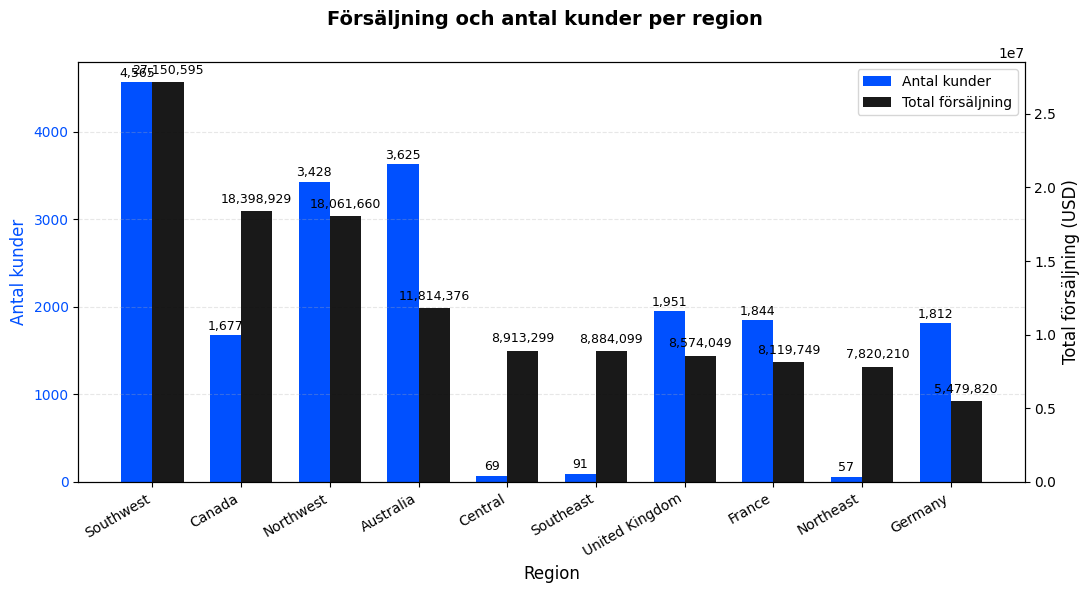

In [13]:
query_vis6 = """
SELECT
    COUNT(DISTINCT c.CustomerID) AS CustomerCount,
    st.Name AS Region,
    SUM(soh.TotalDue) AS TotalSales
FROM Sales.Customer c
INNER JOIN Sales.SalesOrderHeader soh ON c.CustomerID = soh.CustomerID
INNER JOIN Sales.SalesTerritory st ON soh.TerritoryID = st.TerritoryID
GROUP BY st.Name
ORDER BY TotalSales DESC
"""

df_vis6 = query_df(query_vis6)

x = np.arange(len(df_vis6))
width = 0.35

fig, ax1 = plt.subplots(figsize=(11,6))

bars_customers = ax1.bar(
    x - width/2,
    df_vis6['CustomerCount'],
    width,
    label='Antal kunder',
    color='#0050FF',
    alpha=1.0
)

ax1.set_ylabel('Antal kunder', fontsize=12, color='#0050FF')
ax1.tick_params(axis='y', labelcolor='#0050FF')

ax2 = ax1.twinx()

bars_sales = ax2.bar(
    x + width/2,
    df_vis6['TotalSales'],
    width,
    label='Total försäljning',
    color='black',
    alpha=0.9
)

ax2.set_ylabel('Total försäljning (USD)', fontsize=12, color='black')
ax2.tick_params(axis='y', labelcolor='black')

for bar in bars_customers:
    height = bar.get_height()
    ax1.annotate(
        f'{int(height):,}',
        (bar.get_x() + bar.get_width()/2, height),
        textcoords='offset points',
        xytext=(0, 4),
        ha='center',
        fontsize=9
    )

for bar in bars_sales:
    height = bar.get_height()
    ax2.annotate(
        f'{height:,.0f}',
        (bar.get_x() + bar.get_width()/2, height),
        textcoords='offset points',
        xytext=(0, 6),
        ha='center',
        fontsize=9
    )

ax1.set_xlabel('Region', fontsize=12)
ax1.set_xticks(x)
ax1.set_xticklabels(df_vis6['Region'], rotation=30, ha='right')

fig.suptitle(
    'Försäljning och antal kunder per region',
    fontsize=14,
    fontweight='bold'
)

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2, loc='upper right')

ax1.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

### Försäljning och antal kunder per region
Grafen visar tydliga skillnader mellan regionerna när det gäller både antal kunder och total försäljning. Vissa regioner har många kunder men lägre försäljning, medan andra har färre kunder men högre försäljning per kund. Detta tyder på att det genomsnittliga ordervärdet skiljer sig mellan regionerna.

## Genomsnittligt ordervärde per region och kundtyp
Vilka regioner har högst/lägst genomsnittligt ordervärde, och skiljer det sig mellan individuella kunder och företagskunder?


- Beräkna total försäljning / antal ordrar per region och dela upp på kundtyp (Store vs Individual)
- Skapa grupperat stapeldiagram
- Analysera resultatet: Jämför Store vs Individual - vilken grupp har högre ordervärde? Skiljer det sig mellan regioner? Vad kan förklara skillnaderna? Vilken region + kundtyp-kombination har högst ordervärde?

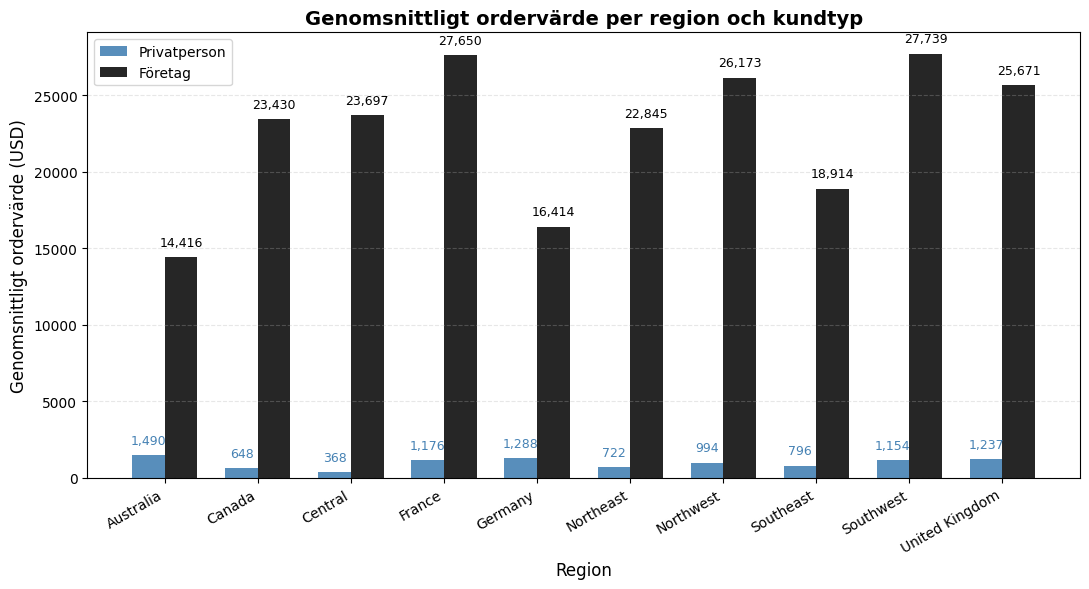

In [14]:
query_vis7 = """
SELECT
    st.Name AS Region,
    CASE 
        WHEN c.StoreID IS NOT NULL THEN 'Store'
		ELSE 'Individual'
    END AS CustomerType,
    SUM(soh.TotalDue) / COUNT(DISTINCT soh.SalesOrderID) AS OrderValue
FROM Sales.SalesOrderHeader soh
LEFT JOIN Sales.Customer c ON soh.CustomerID = c.CustomerID
INNER JOIN Sales.SalesTerritory st ON soh.TerritoryID = st.TerritoryID
GROUP BY
    st.Name,
    CASE 
        WHEN c.StoreID IS NOT NULL THEN 'Store'
		ELSE 'Individual'
    END
ORDER BY
    OrderValue DESC
    """

df_vis7 = query_df(query_vis7)

df_pivot = df_vis7.pivot(
    index='Region',
    columns='CustomerType',
    values='OrderValue'
).fillna(0)

x = np.arange(len(df_pivot))
width = 0.35

fig, ax = plt.subplots(figsize=(11,6))

bars_individual = ax.bar(
    x - width/2,
    df_pivot['Individual'],
    width,
    label='Privatperson',
    color='steelblue',
    alpha=0.9
)

bars_store = ax.bar(
    x + width/2,
    df_pivot['Store'],
    width,
    label='Företag',
    color='black',
    alpha=0.85
)

for bar in bars_individual:
    height = bar.get_height()
    ax.annotate(
        f'{height:,.0f}',
        xy=(bar.get_x() + bar.get_width()/2, height),
        xytext=(0, 6),               
        textcoords='offset points',
        ha='center',
        va='bottom',
        fontsize=9,
        color='steelblue'
    )

for bar in bars_store:
    height = bar.get_height()
    ax.annotate(
        f'{height:,.0f}',
        xy=(bar.get_x() + bar.get_width()/2, height),
        xytext=(0, 6),                
        textcoords='offset points',
        ha='center',
        va='bottom',
        fontsize=9,
        color='black'
    )

ax.set_xlabel('Region', fontsize=12)
ax.set_ylabel('Genomsnittligt ordervärde (USD)', fontsize=12)
ax.set_title(
    'Genomsnittligt ordervärde per region och kundtyp',
    fontsize=14,
    fontweight='bold'
)

ax.set_xticks(x)
ax.set_xticklabels(df_pivot.index, rotation=30, ha='right')

ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

### Insikter: Genomsnittligt ordervärde per region och kundtyp
Företagskunder har ett betydligt högre genomsnittligt ordervärde än privatpersoner i samtliga regioner. Den högsta nivån finns hos företagskunder i regionen Southwest, med ett genomsnittligt ordervärde på cirka 27 700 USD, vilket motsvarar runt 257 000 SEK. Detta beror troligen på att företag ofta gör större beställningar än privatpersoner. Skillnaderna mellan regionerna är också tydligare för företag, vilket kan förklaras av variationer i företagsmarknadens storlek, lokala prisnivåer eller valutor.